In [15]:
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import nltk

In [2]:
# Load anthology with all information
df = pd.read_csv("data/anthology_conferences.csv", sep="|", keep_default_na=False,
                 converters={"semantic_scholar_keywords":lambda x: x.strip("[]").replace("'", "").split(", "),
                            "cso_syntactic":lambda x: x.strip("[]").replace("'", "").split(", "),
                            "cso_semantic":lambda x: x.strip("[]").replace("'", "").split(", "),
                            "cso_union":lambda x: x.strip("[]").replace("'", "").split(", "),
                            "cso_enhanced":lambda x: x.strip("[]").replace("'", "").split(", ")})
df[:2]

,url,publisher,address,year,month,editor,title,ENTRYTYPE,ID,pages,...,note,pdf,abstract,semantic_scholar,semantic_scholar_authorIds,semantic_scholar_keywords,cso_syntactic,cso_semantic,cso_union,cso_enhanced
0,https://www.aclweb.org/anthology/2020.acl-main.1,Association for Computational Linguistics,Online,2020,July,,Learning to Understand Child-directed and Adul...,inproceedings,gelderloos-etal-2020-learning,1--6,...,,2020.acl-main.1.pdf,Speech directed to children differs from adult...,2020.acl-main.1.json,"['7805500', '2756960', '103538973']","[1017215, 1588157]","[linguistics, acoustics, language acquisition,...","[speech signals, synthetic speech, linguistics...","[linguistics, automatic speech recognition, ac...","[speech recognition, signal processing, educat..."
1,https://www.aclweb.org/anthology/2020.acl-main.2,Association for Computational Linguistics,Online,2020,July,,Predicting Depression in Screening Interviews ...,inproceedings,rinaldi-etal-2020-predicting,7--18,...,,2020.acl-main.2.pdf,Despite the pervasiveness of clinical depressi...,2020.acl-main.2.json,"['19320780', '2457504', '37202877']",[8505],"[linguistics, pattern languages, psycholinguis...","[latent variable, latent factor, linguistics, ...","[latent factor, linguistics, dialogue, pattern...","[matrix factorizations, argumentation, speech ..."


In [3]:
# List of abstracts
abstracts = df["abstract"].tolist()
# List of titles
titles = df["title"].tolist()
# List of abstracts concatenated with abstracts
titles_abstracts = [titles[i] + "\n" + abstracts[i] for i in range(len(abstracts))]
# List of abstracts concatenated with ' [SEP] ' and abstracts
titles_sep_abstracts = [titles[i] + " [SEP] " + abstracts[i] for i in range(len(abstracts))]

In [4]:
# Calculate length distribution titles
title_lengths = []
max_length = 0
for text in titles:
    length = len(nltk.word_tokenize(text))
    title_lengths.append(length)
    if length > max_length:
        max_length = length
print("Max text length:", max_length)
TITLE_SEQ_LENGTH = max_length

Max text length: 30


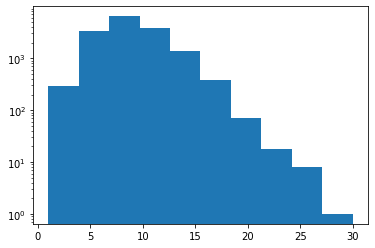

In [5]:
plt.hist(title_lengths, log=True)
plt.show()

In [6]:
# Calculate length distribution titles + abstracts
title_abstract_lengths = []
max_length = 0
for text in titles_sep_abstracts:
    length = len(nltk.word_tokenize(text))
    title_abstract_lengths.append(length)
    if length > max_length:
        max_length = length
print("Max text length:", max_length)

Max text length: 4614


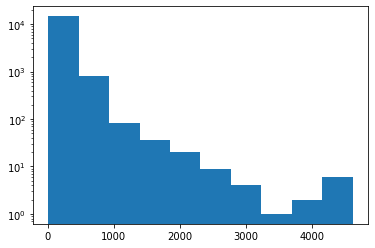

In [7]:
plt.hist(title_abstract_lengths, log=True)
plt.show()

In [8]:
TITLE_ABSTRACT_SEQ_LENGTH = 512

In [9]:
# Create doc2vec embeddings
def doc2vec(texts, vector_size=300, window=5, workers=6):
    documents = [TaggedDocument(simple_preprocess(remove_stopwords(text)), [i]) for i, text in enumerate(texts)]
    model = Doc2Vec(documents, vector_size=vector_size, window=window, workers=workers)
    
    embeddings = []
    for text in texts:
        embeddings.append(model.infer_vector([text]))
    
    return embeddings

In [10]:
# Create sentenceBERT embeddings
def sentenceBERT(texts, pretrained='allenai-specter', convert_to_tensor=False, max_seq_length=300):
    model = SentenceTransformer(pretrained, device='cuda')
    model.max_seq_length = max_seq_length
    embeddings = model.encode(texts, convert_to_tensor=convert_to_tensor, show_progress_bar=True)
    return embeddings

In [11]:
# Save embeddings with their texts in pickle file
def store_embeddings(texts, embeddings, filename='embeddings.pkl'):
    with open('data/embeddings/' + filename, "wb") as fOut:
        pickle.dump({'texts': texts, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# List of pretrained models to create embeddings with
bert_pretrained_models = ['paraphrase-distilroberta-base-v2', 'allenai-specter', 'paraphrase-TinyBERT-L6-v2', 'paraphrase-mpnet-base-v2']

In [13]:
# Create embeddings only for titles and for all pretrained BERT models
print("Creating " + str(len(titles)) + " embeddings of titles for " + str(len(bert_pretrained_models)) + " pretrained bert models...\n")

for pretrained_model in bert_pretrained_models:
    try:
        print(pretrained_model)
        embeddings_titles = sentenceBERT(titles, pretrained=pretrained_model, max_seq_length=TITLE_SEQ_LENGTH) 
        store_embeddings(titles, embeddings_titles, filename=pretrained_model + "_titles.pkl")
    except:
        print("Could not create embeddings for model '" + pretrained_model + "'")

Creating 15713 embeddings of titles for 4 pretrained bert models...


Batches:   0%|          | 0/492 [00:00<?, ?it/s]

Batches:   0%|          | 0/492 [00:00<?, ?it/s]

  0%|          | 0.00/249M [00:00<?, ?B/s]

Batches:   0%|          | 0/492 [00:00<?, ?it/s]

Batches:   0%|          | 0/492 [00:00<?, ?it/s]

In [14]:
# Create embeddings for titles and abstracts and for all pretrained BERT models
print("Creating " + str(len(titles_sep_abstracts)) + " embeddings of titles+abstracts for " + str(len(bert_pretrained_models)) + " pretrained bert models...\n")

for pretrained_model in bert_pretrained_models:
    try:
        print(pretrained_model)
        embeddings_titles_abstracts = sentenceBERT(titles_sep_abstracts, pretrained=pretrained_model, max_seq_length=TITLE_ABSTRACT_SEQ_LENGTH) 
        store_embeddings(titles_sep_abstracts, embeddings_titles_abstracts, filename=pretrained_model + "_titles_abstracts.pkl")
    except:
        print("Could not create embeddings for model '" + pretrained_model + "'")

Creating 15713 embeddings of titles+abstracts for 4 pretrained bert models...


Batches:   0%|          | 0/492 [00:00<?, ?it/s]

Batches:   0%|          | 0/492 [00:00<?, ?it/s]

Batches:   0%|          | 0/492 [00:00<?, ?it/s]

Batches:   0%|          | 0/492 [00:00<?, ?it/s]

In [32]:
# Create embeddings for titles and abstracts with averaged embeddings for all sentences and for all pretrained BERT models
print("Creating " + str(len(titles_sep_abstracts)) + " embeddings of titles+abstracts for " + str(len(bert_pretrained_models)) + " pretrained bert models...\n")

for pretrained_model in bert_pretrained_models:
    assert(len(titles) == len(abstracts))
    
    final_embeddings = []
    
    num_sentences_per_paper = []
    
    try:
        print(pretrained_model)
        
        all_sentences = []
        for i, title in enumerate(titles):
            sentences = [title]
            sentences.extend(nltk.sent_tokenize(abstracts[i]))
            num_sentences_per_paper.append(len(sentences))
            if len(sentences) < 1:
                print("Warning:", len(sentences))
            all_sentences.extend(sentences)
            
        embeddings = sentenceBERT(all_sentences, pretrained=pretrained_model, max_seq_length=TITLE_ABSTRACT_SEQ_LENGTH)
        
        for i, _ in enumerate(titles): 
            current_embeddings = embeddings[:num_sentences_per_paper[i]]
            embeddings = embeddings[num_sentences_per_paper[i]:]
            
            mean_embedding = np.mean(current_embeddings, axis=0)
            final_embeddings.append(mean_embedding)
            
        assert(len(final_embeddings) == len(titles))
        store_embeddings(titles_sep_abstracts, np.array(final_embeddings), filename=pretrained_model + "_titles_abstracts_sent_mean.pkl")
    except:
        print("Could not create embeddings for model '" + pretrained_model + "'")

Creating 15713 embeddings of titles+abstracts for 4 pretrained bert models...

paraphrase-distilroberta-base-v2


Batches:   0%|          | 0/4066 [00:00<?, ?it/s]

allenai-specter


Batches:   0%|          | 0/4066 [00:00<?, ?it/s]

paraphrase-TinyBERT-L6-v2


Batches:   0%|          | 0/4066 [00:00<?, ?it/s]

paraphrase-mpnet-base-v2


Batches:   0%|          | 0/4066 [00:00<?, ?it/s]